In [1]:

import numpy as np
import pandas as pd
import pickle
import numpy as np
import random
import time
import os
#os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2
from tqdm import tqdm

import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from keras import optimizers
#from sklearn.metrics import classification_report, confusion_matrix
import sklearn
import seaborn as sn
from keras.callbacks import CSVLogger, LambdaCallback
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
base_dir = '../input/plantvillage-dataset/'

train_dir = os.path.join(base_dir, 'color')
#test_dir = os.path.join(base_dir, 'test')

work_dir = "./"
#data_instance = 64 # 64 256
color_type = 'rgb' # rgb, grayscale
BATCH_SIZE = 32
split = 0.4
shuffle = True

In [3]:
'''
width_shift_range=0.2,
height_shift_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
vertical_flip=True,
#rotation_range=180,
'''
train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=split
                                  )
val_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=split
                                )

In [4]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        batch_size=BATCH_SIZE,
        color_mode=color_type, # grayscale, rgb
        shuffle=shuffle,
        class_mode='categorical',
        subset='training'
        )

Found 32598 images belonging to 38 classes.


In [5]:
num_classes = train_generator.num_classes
total_train_data = train_generator.samples

print(f"total_train_data = {total_train_data}")
print(f"train_generator.image_shape = {train_generator.image_shape}")
print(f"num_classes = {num_classes}")

total_train_data = 32598
train_generator.image_shape = (256, 256, 3)
num_classes = 38


In [6]:
val_generator = val_datagen.flow_from_directory(
        train_dir,
        batch_size=BATCH_SIZE,
        color_mode=color_type,
        shuffle=False,
        class_mode='categorical',
        subset='validation'
        )

Found 21707 images belonging to 38 classes.


In [7]:
total_val_data = val_generator.samples
print(f"total_val_data = {total_val_data}")

total_val_data = 21707


In [8]:
# DenseNet121 ResNet101 ResNet50 DenseNet201 InceptionV3 Xception NASNetLarge ResNet152V2 InceptionResNetV2 EfficientNetB7
impl_type = "TL.DenseNet201" # TransferLearning3D 
dataset = f"PlantVillage.split{split}.DataAug.Kaggle.{color_type}.{train_generator.image_shape[1]}p.DataFlow" # +str(img_size)+"p"
dataset

'PlantVillage.split0.4.DataAug.Kaggle.rgb.256p.DataFlow'

In [9]:
#'''
count_no_improvement = 0
epoch_initial = True
#'''

In [10]:
#NUM_NEURONS = 16
#NUM_LAYERS = 3
#BATCH_SIZE = 16 # 10
NUM_EPOCHS = 300
epochs_completed = 0
LEARNING_RATE = 0.00001
EPSILON = 1e-4
early_stop_after_epochs = 5
DROPOUT = 0.5 # 0.5 0.0
pad = 0

LOSS = 'categorical_crossentropy'
ACTIVATION_FUNCTION = 'elu' # relu sigmoid elu
FINAL_ACTIVATION_FUNCTION = 'softmax'
validation_split = 0.1
kernel_size=(1,1)
pointTrainableAfter = "allDefault" # "allDefault" 160 170
OPTIMIZER = "Adam" # Adam SGD RMSProp
init_weights = "imagenet" # "imagenet" None
modelExt = ".Dense.1024.1024.2048" # .Dense.128.256.512, .512.512.512 .Dense.512.512.512.512.Res
l2_val = 0.001

ext = f".Flatten.l2.{str(l2_val)}.run_1" # run_1 run_2 .DropAfter .momentum0.9
'''
checkpointer_name  = "weights."+dataset+".pad"+str(pad)+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+\
                     modelExt+".actF."+ACTIVATION_FUNCTION+".opt."+OPTIMIZER+".drop."+str(DROPOUT)+".batch"+str(BATCH_SIZE)+ext+".hdf5"
#'''
#'''
checkpointer_name  = "weights."+dataset+"."+impl_type+".wInit."+str(init_weights)+".TrainableAfter."+str(pointTrainableAfter)+\
                     modelExt+".actF."+ACTIVATION_FUNCTION+".opt."+OPTIMIZER+".drop."+str(DROPOUT)+".batch"+str(BATCH_SIZE)+ext+".hdf5"
#'''
log_name = "log."+checkpointer_name[8:-5]+".log"

print('checkpointer_name =', checkpointer_name)
print('log_name =', log_name)
#'''

checkpointer_name = weights.PlantVillage.split0.4.DataAug.Kaggle.rgb.256p.DataFlow.TL.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_1.hdf5
log_name = log.PlantVillage.split0.4.DataAug.Kaggle.rgb.256p.DataFlow.TL.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_1.log


In [11]:
train_generator.image_shape

(256, 256, 3)

In [12]:
#'''
#base_model=DenseNet121(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:]) # `None` (random initialization)
#base_model=ResNet152V2(weights=None, include_top=False, input_shape=np_train_dataset2.shape[1:])
# ResNet152V2 ResNet50 ResNet101 ResNet152 DenseNet201 InceptionV3 Xception NASNetLarge 'imagenet' ResNet152V2 DenseNet121
#inputs = Input(final_train_imageset.shape[1:])
#x = ZeroPadding2D(padding=(pad,pad))(inputs)
#base_model=tf.keras.applications.ResNet50(weights=init_weights, include_top=False, input_tensor=x)
base_model=tf.keras.applications.DenseNet201(weights=init_weights, include_top=False, input_shape=train_generator.image_shape)
x=base_model.output

x = Flatten()(x)

#'''
x = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)
#x_copy = x
x = Dropout(DROPOUT)(x)
x = Dense(1024, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)
x = Dropout(DROPOUT)(x)
x = Dense(2048, kernel_regularizer=tf.keras.regularizers.l2(l2_val), activation=ACTIVATION_FUNCTION)(x)
x = Dropout(DROPOUT)(x)
#x = Add()([x,x_copy])
#'''
outputs=Dense(num_classes,activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=outputs)
#model.summary()
#'''

74842112/74836368 [==============================] - 1s 0us/step


In [13]:
'''
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=True, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64
)
#'''

"\ntf.keras.utils.plot_model(\n    model, to_file='model.png', show_shapes=True, show_dtype=False,\n    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=64\n)\n#"

In [14]:
count_trainable = 0
count_non_trainable = 0

#'''
if pointTrainableAfter == "allDefault":
    for layer in model.layers:
        layer.trainable=True
        count_trainable += 1
elif pointTrainableAfter > 0:
    for layer in model.layers[:pointTrainableAfter]: # [:-pointTrainableAfter]
        layer.trainable=False
        count_non_trainable += 1
    for layer in model.layers[pointTrainableAfter:]: # [-pointTrainableAfter:]
        layer.trainable=True
        count_trainable += 1
#'''

'''
for layer in model.layers:
    layer.trainable=True
    count_trainable += 1
#'''

print("count_non_trainable =", count_non_trainable)
print("count_trainable =", count_trainable)
print("Total number of layers =", count_non_trainable+count_trainable)

count_non_trainable = 0
count_trainable = 715
Total number of layers = 715


In [15]:
# "RMSProp" "SGD" "Adam" "Adamax" "Adadelta" "Adagrad" "SGD"
#optimizer = tf.keras.optimizers.RMSprop(lr = LEARNING_RATE, epsilon=EPSILON)

if OPTIMIZER == "RMSProp":
    optimizer = tf.keras.optimizers.RMSprop(lr = LEARNING_RATE, epsilon=EPSILON)
elif OPTIMIZER == "Adam":
    optimizer = tf.keras.optimizers.Adam(lr = LEARNING_RATE, epsilon=EPSILON, beta_1=0.9, beta_2=0.999)
elif OPTIMIZER == "Adamax":
    optimizer = tf.keras.optimizers.Adamax(lr = LEARNING_RATE, epsilon=EPSILON, beta_1=0.9, beta_2=0.999)
elif OPTIMIZER == "Adadelta":
    optimizer = tf.keras.optimizers.Adadelta(lr = LEARNING_RATE, epsilon=EPSILON, rho=0.95)
elif OPTIMIZER == "Adagrad":
    optimizer = tf.keras.optimizers.Adagrad(lr = LEARNING_RATE, epsilon=EPSILON, initial_accumulator_value=0.1)
elif OPTIMIZER == "SGD":
    optimizer = tf.keras.optimizers.SGD(lr = LEARNING_RATE, momentum=0.9)

model.compile(
    #optimizer=OPTIMIZER,
    optimizer=optimizer,
    loss=LOSS,
    metrics=['accuracy','AUC']
)

print("OPTIMIZER =", OPTIMIZER)

OPTIMIZER = Adam


In [16]:
# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath = work_dir+checkpointer_name, 
                               #monitor='val_accuracy',
                               monitor='val_loss',
                               save_weights_only=False,  
                               mode='auto', 
                               verbose = 0, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                               save_best_only =False
                               )
checkpointer_best = ModelCheckpoint(filepath = work_dir+"best_"+checkpointer_name, 
                                    monitor='val_loss', 
                                    save_weights_only=False,
                                    mode='auto',  
                                    verbose = 1, 
                                    save_best_only = True
                                    )
early_stopping = EarlyStopping(monitor='loss', patience=early_stop_after_epochs)

In [17]:
'''
if 'count_no_improvement' not in globals():
    count_no_improvement = 0
    print("count_no_improvement =", count_no_improvement)
#'''
'''
count_no_improvement = 0
epoch_initial = False
#'''
min_delta = 0.0009
print("count_no_improvement =", count_no_improvement)

def checkBestPerformance(epoch, logs):
    save_filepath = work_dir+"best_"+checkpointer_name

    global epoch_initial
    if epoch_initial == True:
        epoch_initial = False
        model.save(filepath = save_filepath)
        print(". Model saved!")

    elif epoch_initial == False:
        global count_no_improvement

        log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['val_loss', 'val_accuracy'], engine='python')
        min_val_loss = float(str(min(log_data.val_loss.values))[:6])
        max_val_acc = float(str(max(log_data.val_accuracy.values))[:6])

        current_val_acc = float(str(logs['val_accuracy'])[:6])
        current_val_loss = float(str(logs['val_loss'])[:6])

        if (current_val_acc > max_val_acc) and (abs(current_val_loss-min_val_loss) >= min_delta):
            count_no_improvement = 0
            model.save(filepath = save_filepath)
            print("\nval_accuracy increased from",max_val_acc," to",current_val_acc,"( val_loss =",current_val_loss,").")

        elif (current_val_loss<min_val_loss) and (current_val_acc==max_val_acc):
            count_no_improvement = 0
            model.save(filepath = save_filepath)
            print("\nval_loss decreased to", current_val_loss, ".")

        else:
            count_no_improvement += 1
            print(". count_no_improvement =", count_no_improvement)

        if count_no_improvement >= early_stop_after_epochs:
            global list_callbacks
            del list_callbacks, count_no_improvement
            #print("count_no_improvement =", count_no_improvement, "... list_callbacks =", list_callbacks)

count_no_improvement = 0


In [18]:
epochs_completed = 0
list_callbacks = []
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)

#if 'list_callbacks' in globals():
#    del list_callbacks

try:
    log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
    epochs_completed = log_data.shape[0]

    #if epochs_completed > 0:
    model = load_model(work_dir+checkpointer_name)
    list_callbacks = [checkpointer, LambdaCallback(on_epoch_end=checkBestPerformance), csv_logger]
    print("epochs_completed =", epochs_completed)

except Exception as error:
    if epochs_completed == 0:
        # list_callbacks = [checkpointer, checkpointer_best, csv_logger, early_stopping] 
        list_callbacks = [checkpointer, LambdaCallback(on_epoch_end=checkBestPerformance), csv_logger]
        print("epochs_completed =", epochs_completed)
    elif epochs_completed > 0:
        print(error)

print('checkpointer_name =', checkpointer_name)

epochs_completed = 0
checkpointer_name = weights.PlantVillage.split0.4.DataAug.Kaggle.rgb.256p.DataFlow.TL.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_1.hdf5


In [19]:
print('checkpointer_name =', checkpointer_name)
print("Previously completed epochs =", epochs_completed)
print("count_no_improvement =", count_no_improvement, "\n")

#'''
try:
    start_time = time.time()
    history = model.fit(train_generator, 
                        steps_per_epoch=total_train_data // BATCH_SIZE,
                        shuffle=False, 
                        epochs = NUM_EPOCHS - epochs_completed, 
                        validation_data=val_generator,
                        validation_steps=total_val_data // BATCH_SIZE,
                        callbacks=list_callbacks
                        )
    elapsed_time = time.time() - start_time 
    print("\nTime elapsed: ", elapsed_time)

except Exception as error:
    print("\nError:", error)
#'''

checkpointer_name = weights.PlantVillage.split0.4.DataAug.Kaggle.rgb.256p.DataFlow.TL.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_1.hdf5
Previously completed epochs = 0
count_no_improvement = 0 

Epoch 1/300
1018/1018 [==============================] - 884s 846ms/step - loss: 7.0921 - accuracy: 0.3752 - auc: 0.8215 - val_loss: 4.4191 - val_accuracy: 0.9276 - val_auc: 0.9981
. Model saved!
Epoch 2/300
1018/1018 [==============================] - 648s 637ms/step - loss: 4.6698 - accuracy: 0.8324 - auc: 0.9908 - val_loss: 4.0122 - val_accuracy: 0.9718 - val_auc: 0.9988

val_accuracy increased from 0.9276  to 0.9717 ( val_loss = 4.0122 ).
Epoch 3/300
1018/1018 [==============================] - 650s 638ms/step - loss: 4.1451 - accuracy: 0.9166 - auc: 0.9957 - val_loss: 3.7762 - val_accuracy: 0.9770 - val_auc: 0.9986

val_accuracy increased from 0.9717  to 0.977 ( val_loss = 3.7762 ).
Epoch 4/300
1018/1018

KeyboardInterrupt: 

In [ ]:
# weights.PlantVillage.split0.4.DataAug.Kaggle.rgb.256p.DataFlow.TL.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_1.hdf5


In [ ]:
'''
Record: : (99.32%)
---

#'''

csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)
log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
epochs_completed = log_data.shape[0]

result = model.evaluate(val_generator, steps=total_val_data)
print("Test Acc: {}, AUC (ROC): {}, Test Loss: {}: ep{}, {}\n".format(round(result[1],4), round(result[2],4), round(result[0],4), epochs_completed, checkpointer_name))


In [20]:
#checkpointer_name = "weights.Fashion.DenseNet121.wInit.None.TrainableAfterallDefault.opt.SGD.drop.0.0.batch32.Flatten.run_1.hdf5"
model_loaded = load_model(work_dir+"best_"+checkpointer_name)
print("Loaded "+work_dir+"best_"+checkpointer_name+".")

Loaded ./best_weights.PlantVillage.split0.4.DataAug.Kaggle.rgb.256p.DataFlow.TL.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_1.hdf5.


In [22]:
'''
Record: Notebook_PV_Split0.4: (99.32%)
;
---
Test Acc: 0.9943, AUC (ROC): 0.9996, Test Loss: 2.8474: ep0, weights.PlantVillage.split0.4.DataAug.Kaggle.rgb.256p.DataFlow.TL.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_1.hdf5

'''
'''
csv_logger = CSVLogger(work_dir+log_name, separator=',', append=True)
log_data = pd.read_csv(work_dir+log_name, sep=',', usecols=['epoch'], engine='python')
epochs_completed = log_data.shape[0]
#'''

result2 = model_loaded.evaluate(val_generator, steps=total_val_data // BATCH_SIZE)
#print("nLayers: {}, nNeurons: {}, DROPOUT: {}, Test Acc: {}, Test Loss: {}".format(NUM_LAYERS, NUM_NEURONS, DROPOUT, round(result2[1], 4), round(result2[0], 4)))
print("Test Acc: {}, AUC (ROC): {}, Test Loss: {}: ep{}, {}\n".format(round(result2[1],4), round(result2[2],4), round(result2[0],4), epochs_completed, checkpointer_name))


678/678 [==============================] - 85s 126ms/step - loss: 2.8474 - accuracy: 0.9943 - auc: 0.9996
Test Acc: 0.9943, AUC (ROC): 0.9996, Test Loss: 2.8474: ep0, weights.PlantVillage.split0.4.DataAug.Kaggle.rgb.256p.DataFlow.TL.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_1.hdf5



In [23]:
import csv

with open(work_dir+'Records.csv', "a") as fp:
    wr = csv.writer(fp, dialect='excel')
    try:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4), elapsed_time])
    except:
        wr.writerow([checkpointer_name[8:-5], round(result2[1], 4), round(result2[0], 4)])
print("Saved results.")

Saved results.


In [24]:
#Confution Matrix and Classification Report
#'''
Y_pred = model_loaded.predict_generator(val_generator, verbose=1)
y_true = val_generator.classes
#'''
#'''
save_predictions_filename = f"Y_pred.{checkpointer_name[8:-5]}"
save_true_filename = f"y_true.{checkpointer_name[8:-5]}"

np.save(f"{work_dir}{save_predictions_filename}", Y_pred, allow_pickle=True)
np.save(f"{work_dir}{save_true_filename}", y_true, allow_pickle=True)

print(f"Saved: {work_dir}{save_predictions_filename}")
print(f"Saved: {work_dir}{save_true_filename}")
#'''

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


679/679 [==============================] - 84s 120ms/step
Saved: ./Y_pred.PlantVillage.split0.4.DataAug.Kaggle.rgb.256p.DataFlow.TL.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_1
Saved: ./y_true.PlantVillage.split0.4.DataAug.Kaggle.rgb.256p.DataFlow.TL.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_1


In [25]:
Y_pred_loaded = np.load(f"{work_dir}{save_predictions_filename}.npy", allow_pickle=True)
print(f"Y_pred_loaded.shape = {Y_pred_loaded.shape}")

Y_pred_loaded.shape = (21707, 38)


In [26]:
y_pred = np.argmax(Y_pred_loaded, axis=1)

In [27]:
y_true = val_generator.classes

In [28]:
list_class_names_in_generator = list(val_generator.class_indices.values())
list_class_names_in_generator[:5]

[0, 1, 2, 3, 4]

In [29]:
list_y_true_rearranged = []
list_y_pred_rearranged = []

for true_class,pred_class in zip(y_true,y_pred):
    y_true_rearranged = int(list_class_names_in_generator[true_class])
    y_pred_rearranged = int(list_class_names_in_generator[pred_class])

    list_y_true_rearranged.append(y_true_rearranged)
    list_y_pred_rearranged.append(y_pred_rearranged)

In [30]:
np_y_true_rearranged = np.array(list_y_true_rearranged)
np_y_pred_rearranged = np.array(list_y_pred_rearranged)

print(f"np_y_true_rearranged.shape = {np_y_true_rearranged.shape}")
print(f"np_y_pred_rearranged.shape = {np_y_pred_rearranged.shape}")
#print(f"np_y_true_rearranged: {np_y_true_rearranged}")
#print(f"np_y_pred_rearranged: {np_y_pred_rearranged}")

np_y_true_rearranged.shape = (21707,)
np_y_pred_rearranged.shape = (21707,)


In [31]:
print(f"np_y_true_rearranged.shape = {np_y_true_rearranged.shape}\n")

index = -5
print(f"y_true[{index}:] = {y_true[index:]}")
print(f"y_pred[{index}:] = {y_pred[index:]}\n")
print(f"np_y_true_rearranged[{index}:] = {np_y_true_rearranged[index:]}")
print(f"np_y_pred_rearranged[{index}:] = {np_y_pred_rearranged[index:]}\n")
print(f"np.unique(np_y_true_rearranged) = {np.unique(np_y_true_rearranged)}")
print(f"np.unique(np_y_pred_rearranged) = {np.unique(np_y_pred_rearranged)}")

np_y_true_rearranged.shape = (21707,)

y_true[-5:] = [37 37 37 37 37]
y_pred[-5:] = [37 37 37 37 37]

np_y_true_rearranged[-5:] = [37 37 37 37 37]
np_y_pred_rearranged[-5:] = [37 37 37 37 37]

np.unique(np_y_true_rearranged) = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
np.unique(np_y_pred_rearranged) = [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]


In [32]:
conf_matrix = sklearn.metrics.confusion_matrix(np_y_true_rearranged, np_y_pred_rearranged)
print(f"Confusion Matrix:\n{conf_matrix}")

Confusion Matrix:
[[ 252    0    0 ...    0    0    0]
 [   0  248    0 ...    0    0    0]
 [   0    0  110 ...    0    0    0]
 ...
 [   0    0    0 ... 2140    0    0]
 [   0    0    0 ...    0  149    0]
 [   0    0    0 ...    0    0  636]]


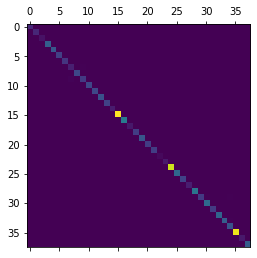

In [33]:
#plt.figure(figsize = (30,30))
plt.matshow(conf_matrix)

In [34]:
df_conf_matrix = pd.DataFrame(conf_matrix, index = [f"Class {i+1}" for i in range(num_classes)],
                  columns = [f"Class {i+1}" for i in range(num_classes)])

In [35]:
list_classes = val_generator.class_indices.keys()
print(f"len(list_classes) = {len(list_classes)}")

len(list_classes) = 38


img_path = ./conf_matrix_PlantVillage.split0.4.DataAug.Kaggle.rgb.256p.DataFlow.TL.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_1.png


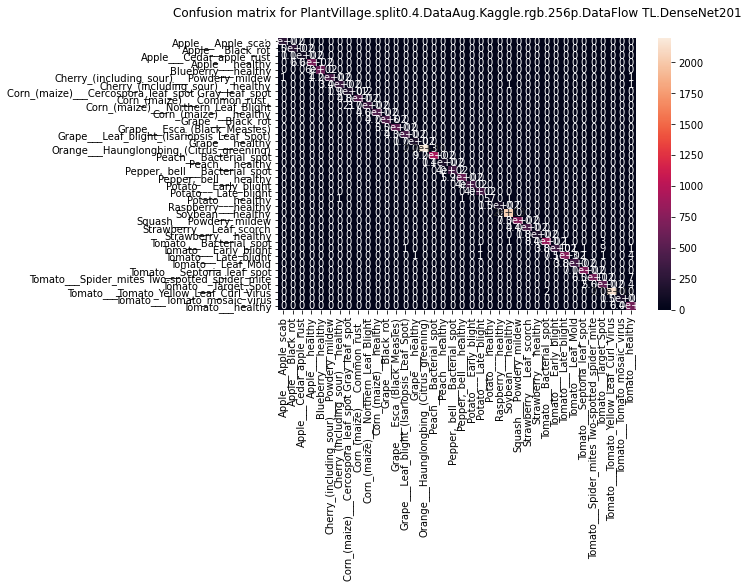

In [36]:
title = "Confusion matrix for "+dataset+" "+impl_type+"\n"
plt.figure(figsize = (8,5))
plt.title(title)
sn.heatmap(df_conf_matrix, annot=True, xticklabels=list_classes, yticklabels=list_classes)

img_path = work_dir+'conf_matrix_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
print(f"img_path = {img_path}")

In [37]:
val_generator.class_indices.keys()

dict_keys(['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato__

In [38]:
#'''
print('Classification Report')
print(sklearn.metrics.classification_report(val_generator.classes, y_pred, target_names=val_generator.class_indices.keys()))
#'''

Classification Report
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00       252
                                 Apple___Black_rot       1.00      1.00      1.00       248
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       110
                                   Apple___healthy       1.00      1.00      1.00       658
                               Blueberry___healthy       1.00      1.00      1.00       600
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      1.00       420
                 Cherry_(including_sour)___healthy       1.00      0.99      1.00       341
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.90      0.94      0.92       205
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       476
               Corn_(maize)___Northern_Leaf_Blight       

In [39]:
log_data = pd.read_csv(work_dir+log_name, sep=',', engine='python') 

In [40]:
# Getting the model history keys 
#history.history.keys()
log_data.head()

,epoch,accuracy,auc,loss,val_accuracy,val_auc,val_loss
0,0,0.565171,0.923567,6.042760,0.927636,0.998101,4.419121
1,1,0.859007,0.992347,4.517224,0.971792,0.998806,4.012231
2,2,0.925620,0.996282,4.056917,0.977046,0.998606,3.776230
3,3,0.949226,0.997828,3.769823,0.984145,0.999013,3.574550
4,4,0.963347,0.998340,3.563010,0.985573,0.999064,3.421372


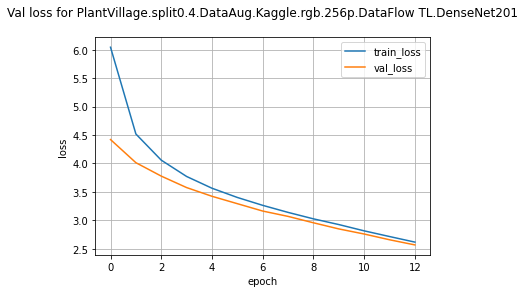

img_path = ./vLoss_PlantVillage.split0.4.DataAug.Kaggle.rgb.256p.DataFlow.TL.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_1.png


In [41]:
# plot the training artifacts
title = "Val loss for "+dataset+" "+impl_type+"\n"

plt.plot(log_data['loss'])
plt.plot(log_data['val_loss'])
plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'], loc = 'best')
plt.grid(b=True, which='major', axis='both')

img_path = work_dir+'vLoss_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)

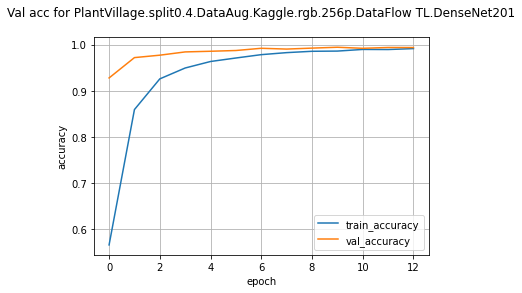

img_path = ./vAcc_PlantVillage.split0.4.DataAug.Kaggle.rgb.256p.DataFlow.TL.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch32.Flatten.l2.0.001.run_1.png


In [42]:
title = "Val acc for "+dataset+" "+impl_type+"\n"

plt.plot(log_data['accuracy'])
plt.plot(log_data['val_accuracy'])
plt.title(title)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'], loc = 'best')
plt.grid(b=True, which='major', axis='both')

img_path = work_dir+'vAcc_'+checkpointer_name[8:-5]+'.png'
plt.savefig(img_path, dpi=600)
plt.show()
print('img_path =', img_path)

In [43]:
from IPython.display import FileLink
FileLink(r'./best_weights.PlantDoc.Kaggle.DataAug.rgb.256p.DataFlow.TL.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.hdf5')


/kaggle/working/best_weights.PlantDoc.Kaggle.DataAug.rgb.256p.DataFlow.TL.DenseNet201.wInit.imagenet.TrainableAfter.allDefault.Dense.1024.1024.2048.actF.elu.opt.Adam.drop.0.5.batch16.Flatten.l2.0.001.run_1.hdf5

In [44]:
'''
while True:
    pass
#'''

'\nwhile True:\n    pass\n#'